In [1]:
# Import von Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# 1 Berechnung der PV-Anlage

In [2]:
def sonnenstand(laengengrad,breitengrad,time):
    ## Zeitgleichung zur Berechnung der wahren Ortszeit
    
    # Zeitgleichung - ergibt die 
    # Abweichung der Sonnenuhr von der mittlerer Ortszeit(MOZ)
    hw1 = 360 / 365 * time['Tag'] # Hilfswinkel 1
    
    z = 0.008 * np.cos(np.radians(hw1)) - 0.122 * np.sin(np.radians(hw1)) \
        - 0.052 * np.cos(np.radians(2 * hw1)) - 0.157 * np.sin(np.radians(2 * hw1)) \
        - 0.001 * np.cos(np.radians(3 * hw1)) - 0.005 * np.sin(np.radians(3 * hw1))

    WOZ = time['Stunden'] + z + 1 / 15 * laengengrad - math.floor(1/15 * laengengrad) # Wahre Ortszeit (WOZ), der Vektor 
    # time.Stunden entspricht der mittleren Ortszeit (MOZ) in Stunden
    
    ## Stundenwinkel bei Berechnung über True Solar Time
    # time.Stunden entspricht hier der Sonnenzeit und nicht der Ortszeit
    # Stw=15*time.Stunden; #Stundenwinkel 
    Stw = 15 * WOZ # Stundenwinkel
    
    ## Berechnung der Deklination
    
    Ew = 0.98630 * (np.array(time.Tag) - 2.8749) + 1.9137 * np.sin(np.radians(0.98630 * (np.array(time.Tag) - 2.8749))) + 102.06 # Ekliptikale Länge in Grad    
    Dw = np.degrees(np.arcsin(-0.3979 * np.sin(np.radians(Ew)))) # Winkel zwischen Äquatorebene und Verbindungs-
    # linie Sonne-Erde. Dieser Winkel wird als Sonnendeklination bezeichnet
    # und schwankt über das Jahr zwischen 23°26,5' und -23°26,5'

    ## Berechnung des Höhenwinkels

    hoehenwinkel = np.degrees(np.arcsin(np.sin(np.radians(Dw)) * np.sin(np.radians(breitengrad)) - np.cos(np.radians(Dw)) * np.cos(np.radians(breitengrad)) * np.cos(np.radians(Stw))))

    ## Berechnung des Azimuts
    # Winkel nach Sonnenuntergang werden hier nicht vollständig abgebildet

    azimutfull = 180 + np.degrees(np.arctan(-np.cos(np.radians(Dw)) * np.sin(np.radians(Stw)) / (-np.cos(np.radians(Dw)) * np.sin(np.radians(breitengrad)) * np.cos(np.radians(Stw)) - np.sin(np.radians(Dw)) * np.cos(np.radians(breitengrad)))))
    
    
    azimutfull[hoehenwinkel < -20] = 0 # Eliminiert
    # unter -20°

    azimutaufteilung = np.reshape(np.array(azimutfull), (96, 365), order="F") # teilt Vektor auf Tage auf
    az1 = azimutaufteilung[0:int((len(time['Stunden'])//365)//2), :] # ergibt Werte für die erste Tageshälfte
    az1[az1 > 220] = az1[az1 > 220] - 180 # Korrektur der Winkel für Abweichungen von über 90° aus Südrichtung
    az11 = az1[0:int(len(time['Stunden'])//365*0.25), :]
    az11[az11 >= 180] = az11[az11 >= 180] - 180
    az1[0:len(az11[:, 0]), :] = az11

    az2 = azimutaufteilung[int((len(time['Stunden'])//365)//2):, :] # ergibt Werte für die zweite Tageshälfte
    az2[(az2 < 150) & (az2 > 0)] = az2[(az2 < 150) & (az2 > 0)] + 180 # Korrektur der Winkel für Abweichungen von über 90° aus Südrichtung
    az22 = az2[int(len(az2[:, 0])*0.5):, :]
    az22[(az22 <= 180) & (az22 > 0)] = az22[(az22 <= 180) & (az22 > 0)] + 180
    az2[int(len(az2[:, 0])-len(az22[:, 0])):, :] = az22
    
    azimutaufteilung = np.concatenate((az1, az2), axis=0) # Zusammenfassung der ersten und zweiten Tageshälfte
    azimut = np.reshape(azimutaufteilung, (35040, ), order="F") # reshape der Tage in einen Vektor aller Winkel über den Jahresverlauf in 15min Intervalle

    return azimut, hoehenwinkel

In [3]:
def jahreserzeugung(E_dir_hor,E_diff_hor,E_G_hor, alpha_s, gamma_s, alpha_e, gamma_e):
    
    #Berechnung des Einstarhlungswinkels
    theta_gen = np.arccos(-np.cos(gamma_s * np.pi / 180) * np.sin(gamma_e * np.pi / 180)
                          *np.cos((alpha_s - alpha_e - 180) * np.pi / 180) 
                          + np.sin(gamma_s* np.pi / 180)* np.cos(gamma_e* np.pi / 180))
    
    #Filter für nicht sinvolle Einstrahlungswinkel
    E_dir_hor[(gamma_s < 5) | (theta_gen > 90) | (E_dir_hor < 0)] = 0
    E_diff_hor[(gamma_s < 5) | (E_diff_hor < 0)] = 0
    E_G_hor[(gamma_s < 5) | (E_G_hor < 0)] = 0
    
    #Berechnung E_dir_gen nach Blabensteiner
    E_dir_gen = E_dir_hor * np.maximum(0, np.cos(theta_gen) / np.sin(gamma_s * np.pi / 180))

    #Berechnung E_refl_gen nach Blabensteiner
    E_refl_gen = E_G_hor * 0.2 * (1 - np.cos(gamma_e * np.pi / 180)) / 2

    #Berechnung E_diff_gen nach Blabensteiner
    E_diff_gen = E_diff_hor * ((1 + np.cos(gamma_e * np.pi / 180)) / 2)

    #Berchnung der gesamten Einstrahlungsleistung auf geneigte Fläche
    Einstrahlungsleistung_geneigt = E_dir_gen + E_refl_gen + E_diff_gen

    return Einstrahlungsleistung_geneigt, E_dir_gen, E_refl_gen, E_diff_gen


In [4]:
def jahreserzeugung_temp(G, temperatur, Modulflaeche, SonstigeVerluste, Modulwirkungsgrad):
    
    G[G == 0] = 10 ** (-10)
    
    #Berechnung des relativen wirkungsgrades mit Formel lt. Folien
    Wirkungsgrad = 1 + ((-0.017162)*np.log(G / 1000))\
            + ((-0.040289)*np.square(np.log(G / 1000)))\
            + ((temperatur + 0.026 * G) - 25)*((-0.004681) + (0.000148 * np.log(G / 1000))\
            + (0.000169 * np.square(np.log(G / 1000))))\
            + 0.000005 * (np.square((temperatur + 0.026 * G) - 25))
    
    #Filtern von Wirkungsgradwerten < 0
    Wirkungsgrad[Wirkungsgrad < 0] = 0
    
    #Berechnung des Jahresertrags mit Formel lt. Folien
    Sum = G  * Wirkungsgrad * Modulwirkungsgrad * Modulflaeche * SonstigeVerluste 
    Jahresertrag = np.sum(Sum)
    Ges_Jahresertrag = np.round(Jahresertrag / 1000, 2)

    return Ges_Jahresertrag , Sum

# 2 Barwertberechnung der PV-Anlage

In [5]:
#extra funktion für barwert berechnung und plot 
def Barwert(zinssatz, systemkosten_kWp, betriebskosten_kWp, lebensdauer, anschlussleistung, zuschuss_kWp, pv_einspeisung, preise_at, titel):
    
    tmp_summe = 0
    barwert_einzelwert = np.empty((lebensdauer,))
    barwert_pro_a = np.empty((lebensdauer + 1,))
    
    einspeisung_anlage = pv_einspeisung #kWh
    
    umsatz_pro_a = np.round(np.sum(einspeisung_anlage.squeeze() * np.repeat(np.array(preise_at), 4))/100, 2) #€/a
    
    for i in range(lebensdauer):
        tmp = (umsatz_pro_a - (betriebskosten_kWp * anschlussleistung)) / ((1 + zinssatz) ** (i + 1)) 
        barwert_einzelwert[i] = tmp
        tmp_summe += barwert_einzelwert[i]
        barwert_pro_a[0] = -((systemkosten_kWp - zuschuss_kWp) * anschlussleistung)
        barwert_pro_a[i + 1] = -((systemkosten_kWp - zuschuss_kWp) * anschlussleistung) + tmp_summe

        
    netto_barwert = -((systemkosten_kWp - zuschuss_kWp) * anschlussleistung) + np.sum(barwert_einzelwert)
    
    print("Nettobarwert " + titel + ": ", round(netto_barwert, 2), "€")
    
    print("Maximale Investitionskosten: ", np.round(np.sum(barwert_einzelwert) + (zuschuss_kWp * anschlussleistung)), "€\n")
    
    Barwert_plot(barwert_pro_a, lebensdauer, "Entwicklung des Barwerts " + titel)  

In [6]:
def Barwert_plot(barwert_pro_a, lebensdauer, titel):
    plt.figure()
    plt.bar(np.arange(0, lebensdauer + 1, 1), barwert_pro_a)
    plt.title(titel)
    plt.xlabel("Lebensdauer [Jahren]")
    plt.ylabel("Barwert [€]")
    plt.grid()
    plt.show

# 3 Überschuss- und Eigenverbrauchsberechnungen 

In [7]:
def Eigenverbrauch_uberschuss(PV_profil_leistung, leistung_haushalte):
    Eigenverbrauch = np.zeros(35040)
    uberschusseinspeisung = np.zeros(35040)
    mehrverbrauch = np.zeros(35040)
    
    for i in range(len(PV_profil_leistung)):
        if(PV_profil_leistung[i]<=leistung_haushalte[i]):
            Eigenverbrauch[i] = PV_profil_leistung[i]
            uberschusseinspeisung[i] = 0
            mehrverbrauch[i] = np.abs(PV_profil_leistung[i]-leistung_haushalte[i]) 
            
        else:
            Eigenverbrauch[i] = leistung_haushalte[i]
            uberschusseinspeisung[i] = PV_profil_leistung[i]-leistung_haushalte[i]
            mehrverbrauch[i] = 0
    
    return Eigenverbrauch, uberschusseinspeisung, mehrverbrauch

In [8]:
def plot_Eigenverbrauch_uberschuss(PV_profil_leistung_data,leistung_haushalt, eigenverbrauch, uberschuss):
    eigenverbrauch = pd.DataFrame(eigenverbrauch)
    uberschuss = pd.DataFrame(uberschuss)
    
    PV_profil_leistung_data_week3 = PV_profil_leistung_data.iloc[1345:2017].values.reshape(-1)
    PV_profil_leistung_data_week25 = PV_profil_leistung_data.iloc[16128:16801].values.reshape(-1)
    eigenverbrauch_week3 = eigenverbrauch.iloc[1345:2017].values.reshape(-1)
    eigenverbrauch_week25 = eigenverbrauch.iloc[16128:16801].values.reshape(-1)
    leisung_week3 = leistung_haushalt.iloc[1345:2017].values.reshape(-1)
    leistung_week25 = leistung_haushalt.iloc[16128:16801].values.reshape(-1)
    
    df = pd.DataFrame({
    'PV_Leistung': PV_profil_leistung_data_week3,
    'Haushalt_Leistung': leisung_week3,
    'Eigenverbrauch': eigenverbrauch_week3,
    }, index=list(range(1345, 2017))
    )
    df2 = pd.DataFrame({
    'PV_Leistung': PV_profil_leistung_data_week25,
    'Haushalt_Leistung': leistung_week25,
    'Eigenverbrauch': eigenverbrauch_week25,
    }, index=list(range(16128, 16801))
    )
    
    ax = df.plot.area(stacked=False,figsize=(12, 6))
    ax.set_xlabel('Woche 3', fontsize=14)
    ax.set_ylabel('Leistung (kW)', fontsize=14)
    ax2 = df2.plot.area(stacked=False,figsize=(12, 6))
    ax2.set_xlabel('Woche 25', fontsize=14)
    ax2.set_ylabel('Leistung (kW)', fontsize=14)


# 4.1 Anwendung der Modelle aus 1 - 3

In [9]:
data_stra = pd.read_csv('Einstrahlungsdaten_Klosterneuburg.csv')
data_time = pd.read_csv('time.csv')

#Benötigte Daten aus bestimmter Spalte einlesen
E_dir_hor = data_stra.loc[0: ,"Direct Horiz"] #spalte aus csv datei mit direct horizontal daten    
E_diff_hor = data_stra.loc[0:,"Diffuse Horiz"] #spalte aus csv datei mit diffuse horizontal daten    
E_G_hor = data_stra.loc[0:, "Global Horiz"] #spalte aus csv datei mit global horizontal daten
data_temp_k = data_stra.loc[0:, "Temperature"] #Temperaturdaten ebenfalls von helioClim
data_temp = data_temp_k - 273.15

# Input - Parameter
laengengrad=16.325
breitengrad=48.305
Modulwirkungsgrad = 0.17 # Wirkungsgrad der Panele
SonstigeVerluste = 0.8 # Wirkungsgrad aller anderen Komponenten...
Installpv = 10 # installierte Leistung der Anlage in kWp
zinssatz = 0.04 #%
betriebskosten_kWp = 4 #€/(kWp*a)
lebensdauer = 25 #a
systemkosten_kWp = 1200 #€/kWp
zuschuss_kWp = min(250, systemkosten_kWp * 0.3)
einspeisetarif = 14.457 #ct/kWh
foerderdauer = 13 #a

#Speicher 
kapazitaet = 10 #kWh
energieinhalt = 0 #kWh
speicher_kosten = 10000 #€
wirkungsgrad_speicher = 0.98 


# Ausrichtung der PV
pv_hoehenwinkel=30 #gamma_e
pv_azimut=180# alpha_e
Modulflaeche = Installpv/(1*Modulwirkungsgrad)


#Jahreserzeugung Basic
alpha_s, gamma_s  = sonnenstand(laengengrad , breitengrad, data_time) #gibt zwei vektor zurück
G, E_dire_gen_sum, E_refl_gen_sum, E_diff_gen_sum = jahreserzeugung(E_dir_hor,E_diff_hor,E_G_hor, alpha_s, gamma_s,pv_azimut,pv_hoehenwinkel)

#Berechnung des Jahresertrags ohne Berücksichtigung der Temperatur-Daten
Erg = np.sum(G)
Jahresertrag = np.round((Erg * Modulflaeche * Modulwirkungsgrad * SonstigeVerluste) / 1000,2)
print("Jahresertrag 2005: ",Jahresertrag,"kWh")

#Jahreserzeugung Temperatur
Jahresertrag_temp, E_gen_temp = jahreserzeugung_temp(G, data_temp, Modulflaeche, SonstigeVerluste, Modulwirkungsgrad)
print("Jahresertrag 2005 mit Temperatur einfluss: ",Jahresertrag_temp,"kWh\n")


Jahresertrag 2005:  10069.92 kWh
Jahresertrag 2005 mit Temperatur einfluss:  8609.67 kWh



Die Anlage mit Standort Klosterneuburg, mit einer Azimutalen ausrichtung richtung Süden und einer Neigung von 30°, erzeugt unter berücksichtigung der Temperaturverluste Jährlich 8600 kWh. Dieser Wert ist für diesen Standort und die Ausrichtung sehr realistisch.   
Da keine anderern Einstrahlungs- und Wetterdaten zur Verfügung standen wurden jene von 2005 als "Standart" angenommen, alle weiteren Berechnungen beziehen sich auf die Jahre 2021 und 2022.

Nettobarwert (Preise aus 2021):  2025.81 €
Maximale Investitionskosten:  14026.0 €

Nettobarwert (Preise aus 2022):  25736.85 €
Maximale Investitionskosten:  37737.0 €



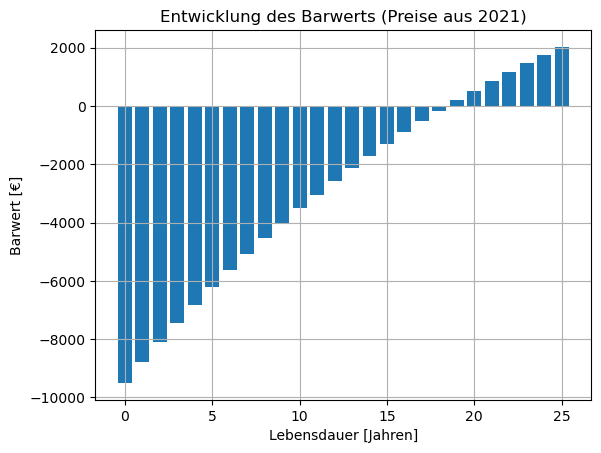

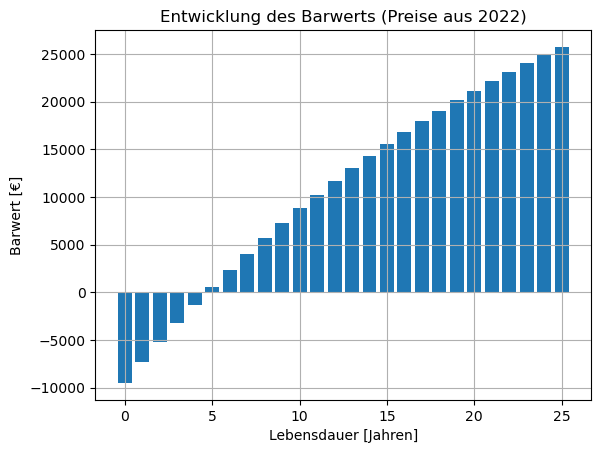

In [10]:
preise21 = pd.read_csv("ENTSOE_prices_for_2021_in_ct_per_kWh.csv")
preise22 = pd.read_csv("ENTSOE_prices_for_2022_in_ct_per_kWh.csv")
pv_einspeisung = E_gen_temp / 1000
preise_at_21 = preise21.loc[0: , "AT"] #ct/kWh
preise_at_22 = preise22.loc[0:, "AT"] #ct/kWh
    
    
Barwert(zinssatz, systemkosten_kWp, betriebskosten_kWp, lebensdauer, Installpv, zuschuss_kWp, pv_einspeisung, preise_at_21, "(Preise aus 2021)")
Barwert(zinssatz, systemkosten_kWp, betriebskosten_kWp, lebensdauer, Installpv, zuschuss_kWp, pv_einspeisung, preise_at_22, "(Preise aus 2022)")

Die Berechnung des Batrwerts der Anlage zeigt, dass sich diese je nach betrachtetem Zeitraum nach 19 Jahren (Jahr 2021 Standart) bzw. nach 5 Jahren (Jahr 2022 Standart) Wirtschaftlich rentiert hat, also der Bawert positiv geworden ist. 

In [11]:
# Leistung Haushalte einlesen - Einheit Wh/4
data_leistung_haushalte = pd.read_csv('LeistungHaushalte.csv', header = None)

# Leistung der Haushalte in Wh
leistung_haushalt = (data_leistung_haushalte.iloc[:, 11]) /1000

# Eigenverbrauch und Überschuss für Haushalt 1 und 2 berechnen (5 kWp)
eigenverbrauch1, uberschuss1, mehrverbrauch = Eigenverbrauch_uberschuss(pv_einspeisung, leistung_haushalt)
print("PV-Anlage\n")
print(f"Eigenverbrauch: {np.round(np.sum(eigenverbrauch1),2) } kWh")
print(f"Überschuss: {np.round(np.sum(uberschuss1), 2)} kWh")
print("Zusätzlicher Bezug aus dem Netz: " , np.round(np.sum(mehrverbrauch),2) , "kWh")

PV-Anlage

Eigenverbrauch: 1641.28 kWh
Überschuss: 6968.39 kWh
Zusätzlicher Bezug aus dem Netz:  2852.98 kWh


Die Zahlen Zeigen, dass ein Teil der im Haushalt benötigten Leistung durch die PV-Anlage erzeugt wird, jedoch wird ein großer Teil der Leistung zur falschen Zeit erzeugt, was dazu führt, dass die Werte der Überschuss einspeisung sehr hoch ausfallen. Dies ist aber gerade dann, wenn die Stromkosten sehr hoch und die abgeltung der erzeugten Energie im Vergleich niedrig ist suboptimal.

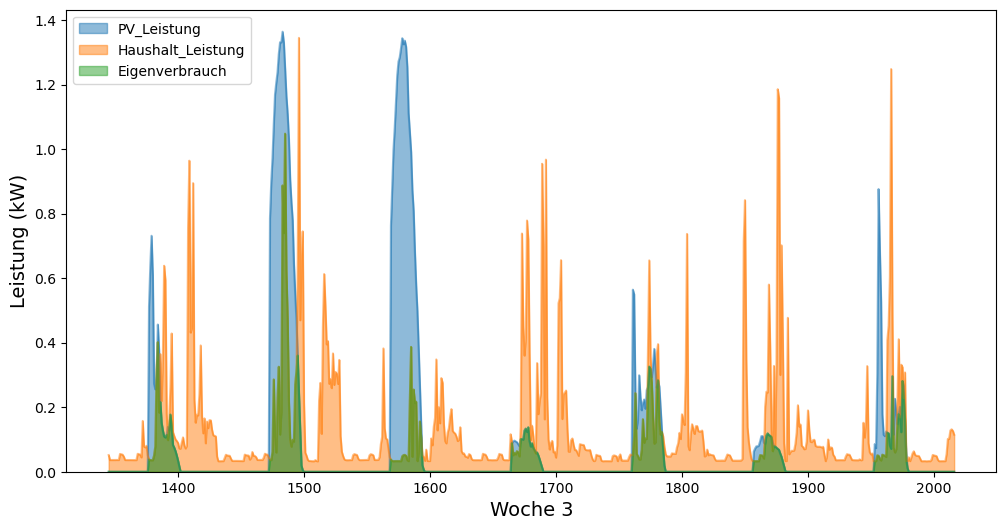

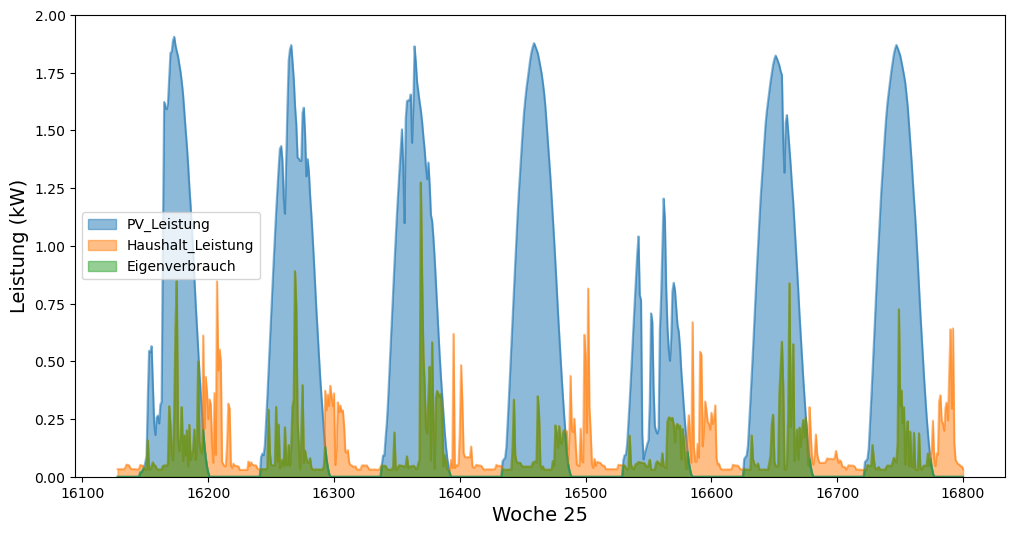

In [12]:
# Plot PV_Leistung, Haushaltleistung and Eigenverbrauch for week 3 and 25
plot_Eigenverbrauch_uberschuss(pv_einspeisung, leistung_haushalt, eigenverbrauch1, uberschuss1)

Die Darstellung der obigen Ergebnisse zeigt, dass in den Wintermonaten ein viel geringerer Anteil des Verbrauchs von der PV-Anlage gedeckt wird. Außerdem ist zu sehen, dass wie beschrieben, die Energie zum falschen Zeitpunkt erzeugt wird (Mittags), jedoch an einem anderen gebraucht wird (Früh oder Abends).  
Dieses Problem soll im weiteren mithilfe eines Speichers verbessert werden.

# 4.2 Barwertberechnung unter Berücksichtigung des Haushaltsverbrauchs

In [13]:
def BarwertHaushalte(eigenverbrauch, ueberschuss, mehr_verbrauch, betriebskosten_kWp, anschlussleistung, zinssatz, zuschuss_kWp, systemkosten_kWp, titel, ohne_PV ):
    einspeisetarif_ueberschuss = 7/100 #€/kWh
    strompreis_durchschnitt = 23.065/100 #€/kWh lt. statista
    tmp_summe = 0
    barwert_einzelwert = np.empty((lebensdauer,))
    barwert_pro_a = np.empty((lebensdauer + 1,))

    if(ohne_PV == 1):
        ausgaben = (eigenverbrauch + mehr_verbrauch) * strompreis_durchschnitt #€/a
        einnahmen = 0
    else:
        einnahmen = ueberschuss * einspeisetarif_ueberschuss 
        ausgaben = mehr_verbrauch * strompreis_durchschnitt
        
        
    for i in range(lebensdauer):
        tmp = (einnahmen - ((betriebskosten_kWp * anschlussleistung) + ausgaben)) / ((1 + zinssatz) ** (i + 1)) 
        barwert_einzelwert[i] = tmp
        tmp_summe += barwert_einzelwert[i]
        barwert_pro_a[0] = -((systemkosten_kWp - zuschuss_kWp) * anschlussleistung)
        barwert_pro_a[i + 1] = -((systemkosten_kWp - zuschuss_kWp) * anschlussleistung) + tmp_summe

        
    netto_barwert = -((systemkosten_kWp - zuschuss_kWp) * anschlussleistung) + np.sum(barwert_einzelwert)
    print("Nettobarwert " + titel + ": ", round(netto_barwert,2), " €")
    Barwert_plot(barwert_pro_a, lebensdauer, "Barwertentwicklung " + titel)


Nettobarwert (Haushalt mit PV):  -12784.59  €
Nettobarwert (Haushalt ohne PV):  -25915.04  €


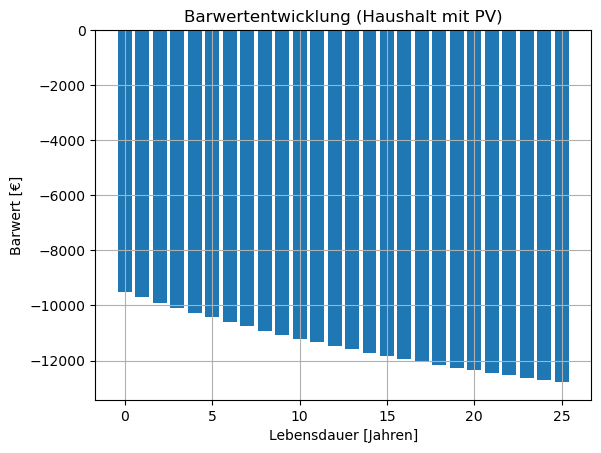

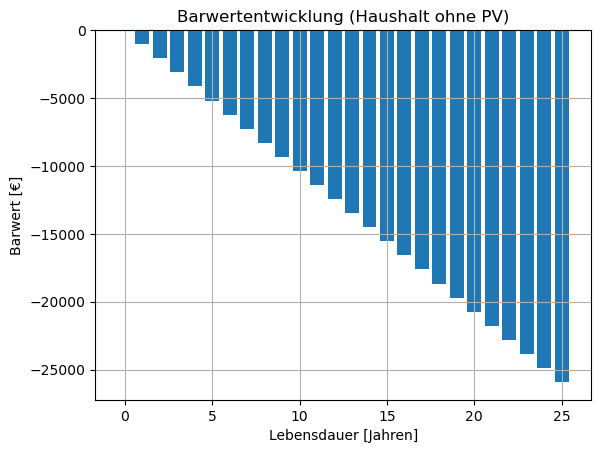

In [14]:
BarwertHaushalte(np.sum(eigenverbrauch1), np.sum(uberschuss1), np.sum(mehrverbrauch), betriebskosten_kWp, Installpv, zinssatz, zuschuss_kWp, systemkosten_kWp, "(Haushalt mit PV)", 0)
BarwertHaushalte(np.sum(eigenverbrauch1), np.sum(uberschuss1), np.sum(mehrverbrauch), 0, 0, 0, 0, 0, "(Haushalt ohne PV)", 1)

Die Barwertberechnung zeigt, dass die Investition in eine PV-Anlage zu einer deutlichen Kostenersparniss führt, zwar wirkt sich die Investition in den ersten 10- 11 Jahren noch negativ aus, jedoch flacht die Kurve dann stark ab, was bei der Berechnung ohne PV-Anlage nicht zu erkennen ist. 

# 5.1 Berechnung der PV-Anlage mit Speicher

In [15]:
def Eigenverbrauch_speicher(PV_profil_leistung, leistung_haushalte, kapazitaet, energieinhalt, wirkungsgrad_speicher):
    Eigenverbrauch = np.zeros(35040)
    uberschusseinspeisung = np.zeros(35040)
    mehrverbrauch = np.zeros(35040)
    entladen = np.zeros(35040)
    
    for i in range(len(PV_profil_leistung)):
        if(PV_profil_leistung[i]<=leistung_haushalte[i]):
            Eigenverbrauch[i] = PV_profil_leistung[i]  
            if(energieinhalt > 0):
                tmp = energieinhalt
                energieinhalt -= (leistung_haushalte[i] - PV_profil_leistung[i]) * (2 - wirkungsgrad_speicher)   
                if(energieinhalt < 0):
                    entladen[i] = tmp
                    mehrverbrauch[i] = abs(energieinhalt)
                    energieinhalt = 0
                else:
                    entladen[i] = tmp - energieinhalt
            else:
                mehrverbrauch[i] = leistung_haushalt[i] - PV_profil_leistung[i]
                
        else:
            Eigenverbrauch[i] = leistung_haushalte[i]
            if(energieinhalt < kapazitaet):
                energieinhalt += PV_profil_leistung[i] - leistung_haushalte[i]
                if(energieinhalt > kapazitaet):
                    uberschusseinspeisung[i] = abs(energieinhalt - kapazitaet)
                    energieinhalt = kapazitaet
            else:
                uberschusseinspeisung[i] = PV_profil_leistung[i] - leistung_haushalte[i]
    
    return Eigenverbrauch, uberschusseinspeisung, mehrverbrauch, energieinhalt, entladen

In [16]:
eigenverbrauch_sp, uberschuss_sp, mehrverbrauch_sp, energieinhalt, entladen_sp = Eigenverbrauch_speicher(pv_einspeisung, leistung_haushalt, kapazitaet, energieinhalt, wirkungsgrad_speicher)

print("Eigenverbrauch: ", np.round(np.sum(eigenverbrauch_sp), 2), "kWh")
print("Überschuss: ", np.round(np.sum(uberschuss_sp), 2), "kWh")
print("Zusätzlicher Bezug aus dem Netz: ", np.round(np.sum(mehrverbrauch_sp), 2), "kWh")

Eigenverbrauch:  1641.28 kWh
Überschuss:  4974.89 kWh
Zusätzlicher Bezug aus dem Netz:  899.23 kWh


Im vergleich zur Berechnung ohne Speicher ist eindeutig zu erkennen, dass viel weniger Leistung aus dem Netz entnommen werden muss, da dieser Anteil durch den Speicher gedeckt wird. Außerdem ist die Überschusseinspeisung geringer, da dieser Anteil verwendet wurde um den Speicher zu laden.

# 5.2  Überschuss- und Eigenverbrauchsberechnungen für Anlage mit         Speicher

In [17]:
def plot_Eigenverbrauch_uberschuss_sp(PV_profil_leistung_data, mehrverbrauch , eigenverbrauch, uberschuss, leistung_haushalt, entladen):
    eigenverbrauch = pd.DataFrame(eigenverbrauch)
    uberschuss = pd.DataFrame(uberschuss)
    
    PV_profil_leistung_data_week3 = PV_profil_leistung_data.iloc[1345:2017].values.reshape(-1)
    PV_profil_leistung_data_week25 = PV_profil_leistung_data.iloc[16128:16801].values.reshape(-1)
    eigenverbrauch_week3 = eigenverbrauch.iloc[1345:2017].values.reshape(-1)
    eigenverbrauch_week25 = eigenverbrauch.iloc[16128:16801].values.reshape(-1)
    mehrverbrauch_week3 = mehrverbrauch.iloc[1345:2017].values.reshape(-1)
    mehrverbrauch_week25 = mehrverbrauch.iloc[16128:16801].values.reshape(-1)
    leistung_week3 = leistung_haushalt.iloc[1345:2017].values.reshape(-1)
    leistung_week25 = leistung_haushalt.iloc[16128:16801].values.reshape(-1)
    entladen_week3 = entladen.iloc[1345:2017].values.reshape(-1)
    entladen_week25 = entladen.iloc[16128:16801].values.reshape(-1)
    
    df = pd.DataFrame({
    'PV_Leistung': PV_profil_leistung_data_week3,
    'Netz_Bezug': mehrverbrauch_week3,
    'Eigenverbrauch': eigenverbrauch_week3,
    'Speicher_Entladen' : entladen_week3,
    }, index=list(range(1345, 2017))
    )
    df2 = pd.DataFrame({
    'PV_Leistung': PV_profil_leistung_data_week25,
    'Netz_Bezug': mehrverbrauch_week25,
    'Eigenverbrauch': eigenverbrauch_week25,
    'Speicher_Entladen' : entladen_week25,
    }, index=list(range(16128, 16801))
    )
    
    ax = df.plot.area(stacked=False,figsize=(12, 6))
    ax.set_xlabel('Woche 3', fontsize=14)
    ax.set_ylabel('Leistung (kW)', fontsize=14)
    ax2 = df2.plot.area(stacked=False,figsize=(12, 6))
    ax2.set_xlabel('Woche 25', fontsize=14)
    ax2.set_ylabel('Leistung (kW)', fontsize=14)
    


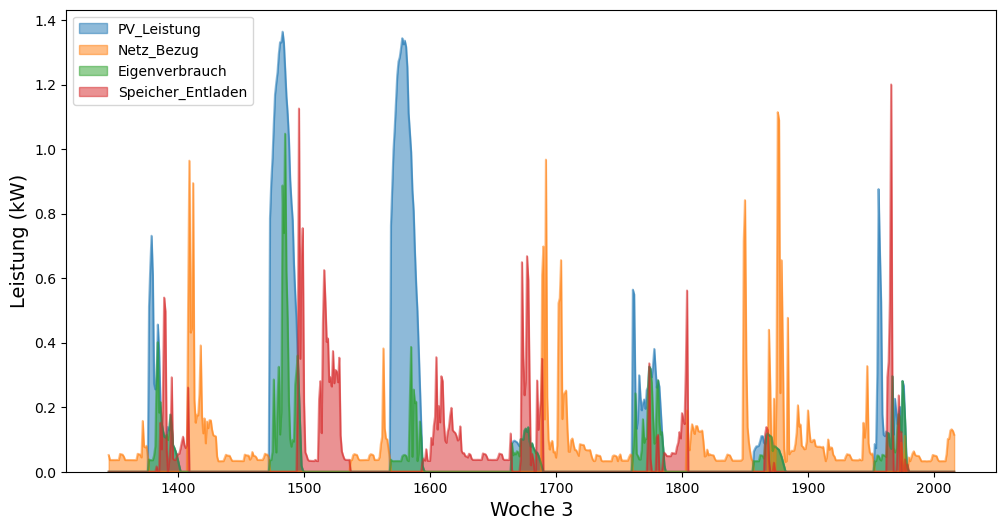

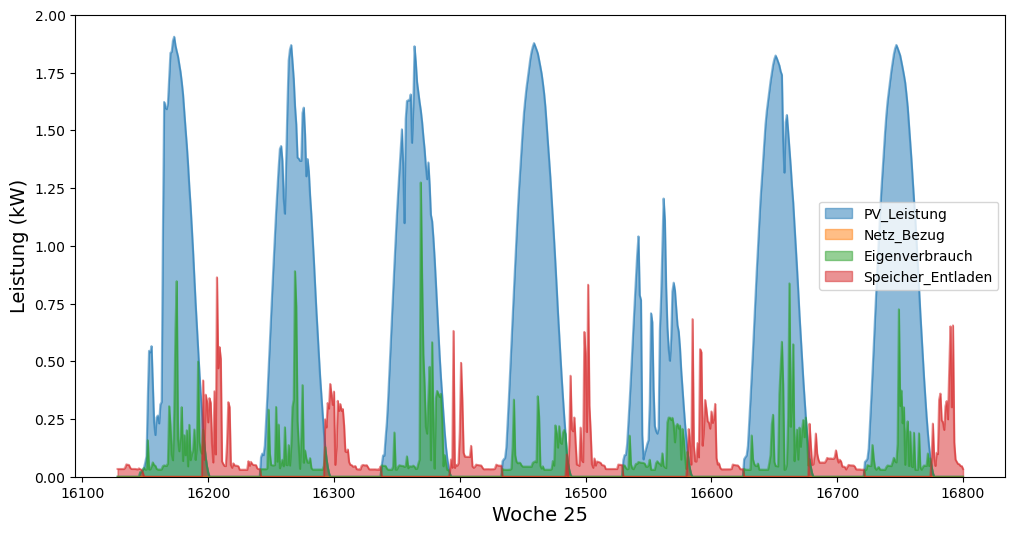

In [18]:
plot_Eigenverbrauch_uberschuss_sp(pv_einspeisung, pd.DataFrame(mehrverbrauch_sp), eigenverbrauch_sp, uberschuss_sp, leistung_haushalt, pd.DataFrame(entladen_sp))

In den obigen Diagrammen ist zu sehen, dass in den Wintermonaten ein Teil des verbrauchs vom Netz gedekct wird, da die Dauer und intensität der Sonne schwächer ist. In den Sommermonaten wird beinahe die gesammte benötigte Leistung entweder direkt von der PV-Anlage erzeugt oder aus dem Speicher entnommen. Dadurch kann die unter tags gespeicherte Energie in der Früh und am Abend genutz werden um die Haushaltsleistung zu decken.

# 5.3 Barwertberechnung unter Berücksichtigung des Haushaltsverbrauchs für Anlage mit Speicher

In [19]:
def BarwertHaushalte_sp(eigenverbrauch, ueberschuss, mehr_verbrauch, betriebskosten_kWp, anschlussleistung, zinssatz, zuschuss_kWp, systemkosten_kWp,  speicher_kosten, titel, ohne_PV ):
    einspeisetarif_ueberschuss = 7/100 #€/kWh
    strompreis_durchschnitt = 23.065/100 #€/kWh lt. statista
    tmp_summe = 0
    barwert_einzelwert = np.empty((lebensdauer,))
    barwert_pro_a = np.empty((lebensdauer + 1,))
    
    if(ohne_PV == 1):
        ausgaben = (eigenverbrauch + mehr_verbrauch) * strompreis_durchschnitt #€/a
        einnahmen = 0
    else:
        einnahmen = ueberschuss * einspeisetarif_ueberschuss
        ausgaben = mehr_verbrauch * strompreis_durchschnitt
        
        
    for i in range(lebensdauer):
        tmp = (einnahmen - ((betriebskosten_kWp * anschlussleistung) + ausgaben)) / ((1 + zinssatz) ** (i + 1)) 
        barwert_einzelwert[i] = tmp
        tmp_summe += barwert_einzelwert[i]
        barwert_pro_a[0] = -(((systemkosten_kWp - zuschuss_kWp) * anschlussleistung) + speicher_kosten)
        barwert_pro_a[i + 1] = -(((systemkosten_kWp - zuschuss_kWp) * anschlussleistung) + speicher_kosten) + tmp_summe

        
    netto_barwert = -(((systemkosten_kWp - zuschuss_kWp) * anschlussleistung) + speicher_kosten) + np.sum(barwert_einzelwert)
    print("Nettobarwert " + titel + ": ", round(netto_barwert,2), " €")
    Barwert_plot(barwert_pro_a, lebensdauer, "Barwertentwicklung " + titel)


Nettobarwert (Haushalt mit PV und Speicher):  -17924.76  €


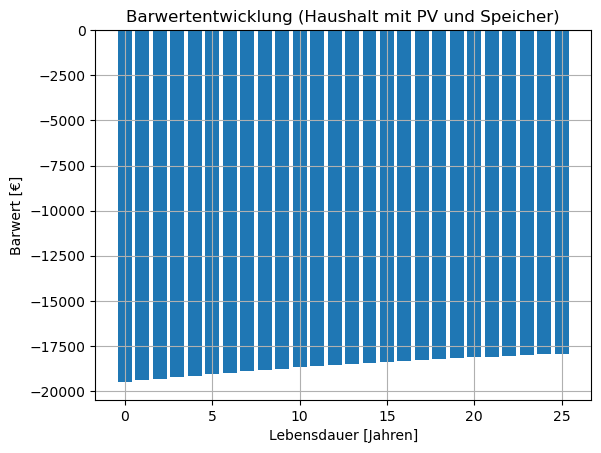

In [20]:
BarwertHaushalte_sp(np.sum(eigenverbrauch_sp), np.sum(uberschuss_sp), np.sum(mehrverbrauch_sp), betriebskosten_kWp, Installpv, zinssatz, zuschuss_kWp, systemkosten_kWp, speicher_kosten, "(Haushalt mit PV und Speicher)", 0)

Bei der Barwertberechnung fällt auf, dass durch den Speicher sehr hohe Investitionskosten auftreten, der gewählte Speicher zählt in diesem Fall auch zu einer gehobenen Preiskategorie. Jedoch entwickelt sich der Barwert trotz hoher investitionskosten positiv und führt eindeutig zu einer ersparnis im vergleich zu einem Haushalt ohne PV-Anlage.

Nettobarwert (Haushalt mit PV und Speicher):  -10368.12  €


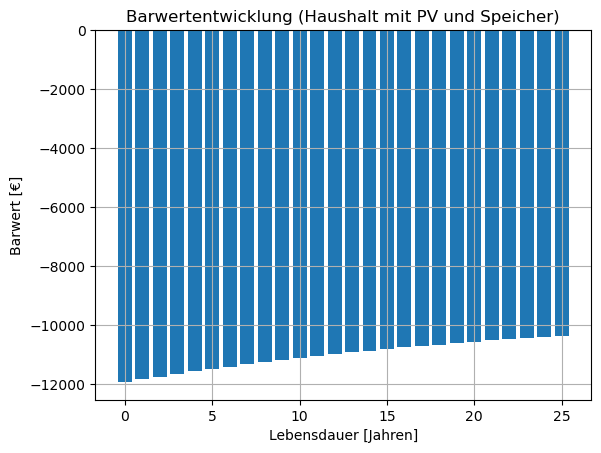

In [21]:
BarwertHaushalte_sp(np.sum(eigenverbrauch_sp), np.sum(uberschuss_sp), np.sum(mehrverbrauch_sp), betriebskosten_kWp, Installpv, zinssatz, zuschuss_kWp, systemkosten_kWp, 2443.36, "(Haushalt mit PV und Speicher)", 0)

Mit einem günstigeren Speicher fällt die Ersparnis nach 25 Jahren besser aus als bei einer PV-Anlage ohne Speicher